In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch, stft, butter, lfilter, sosfilt
from scipy.optimize import curve_fit

In [4]:
def get_psd(data, channel=1, time_unit='s'):
    if time_unit == 's':
        tt = data[0]
    elif time_unit == 'ms':
        tt = data[0] / 1000

    fs = int(np.ceil(1 / (tt[1] - tt[0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

def get_peak_area(data, channel=1, time_unit='ms', fdrive=20000):
    """Integrate to get the area under a driven peak"""
    ff, pp = get_psd(data, channel, time_unit)
    
    peak_idx = int(fdrive / 10)
    lb, ub = peak_idx-10, peak_idx+10
    
    all_idx = np.arange(lb, ub, 1)
    excluding_peak = np.logical_or(all_idx < (peak_idx-3), all_idx > (peak_idx+3))

    area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
    area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

    # Excluding background contribution (which is very small anyway)
    # Take care of 2 pi normalization after numerical integration
    # because we integrated over omega here
    v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)
    
    return v2_drive

def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [5]:
def get_filtered_signal(data, f_hp=10000, f_lp=100000, time_unit='ms', channel=1):
    if time_unit == 's':
        tt = data[0]
    elif time_unit == 'ms':
        tt = data[0] / 1000
        
    fs = int(np.ceil(1 / (tt[1] - tt[0]))) # Sampling rate in Hz
    sos_hp = butter(8, f_hp, 'hp', fs=fs, output='sos')
    sos_lp = butter(8, f_lp, 'lp', fs=fs, output='sos')
    filtered = sosfilt(sos_hp, data[channel])
    filtered_filtered = sosfilt(sos_lp, filtered)
    
    return filtered_filtered

def lowpass_filtered(tod, fs, f_lp=50000):
    sos_lp = butter(8, f_lp, 'lp', fs=fs, output='sos')
    filtered = sosfilt(sos_lp, tod)
    
    return filtered

def highpass_filtered(tod, fs, f_hp=50000):
    sos_hp = butter(8, f_hp, 'hp', fs=fs, output='sos')
    filtered = sosfilt(sos_hp, tod)
    
    return filtered

In [40]:
data_file = r"C:\Users\yuhan\Documents\Data\calibration\20240221_noefield_6e-6.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ffy, ppy = get_psd(data, 1, 'ms')
ffx, ppx = get_psd(data, 2, 'ms')
ffz, ppz = get_psd(data, 3, 'ms')
fff, ppf = get_psd(data, 4, 'ms')

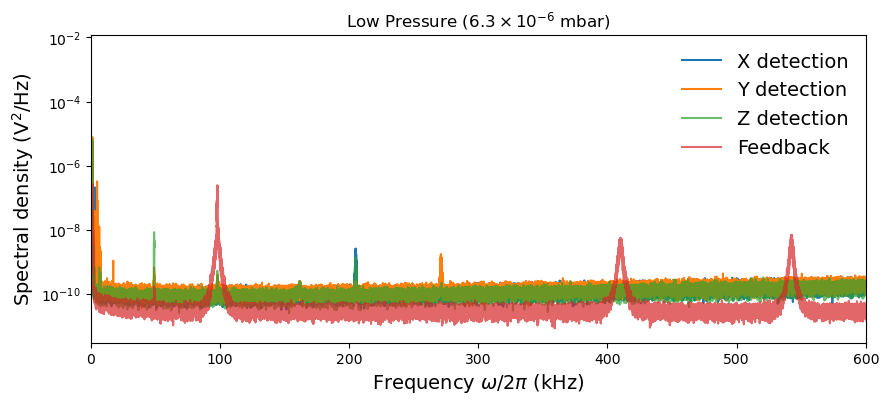

In [13]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(ffx/1000, ppx, label='X detection')
ax.plot(ffy/1000, ppy, label='Y detection')
ax.plot(ffz/1000, ppz, label='Z detection', alpha=0.7)
ax.plot(fff/1000, ppf, label='Feedback', alpha=0.7)
ax.set_xlim(0, 600)

ax.set_title(r'Low Pressure ($6.3 \times 10^{-6}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel('Spectral density (V$^2$/Hz)', fontsize=14)

ax.legend(frameon=False, fontsize=14)
ax.set_yscale('log')

Low Pressure - Amplitude: 613839.1331751272, central frequency: 48989.00878063585 Hz, gamma: 198.78220503267158 Hz


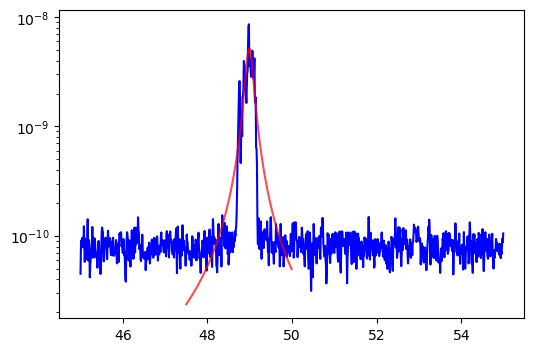

In [41]:
lb, ub = 4500, 5500
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ffz[lb:ub]/1000, ppz[lb:ub], 'b', label='Z detection')
ax.set_yscale('log')

# Fit with a Lorentzian and plot
lb_fit, ub_fit = 4750, 5000
popt, omega_fit, p_fit = fit_peak(ffz[lb_fit:ub_fit]*2*np.pi, ppz[lb_fit:ub_fit], peak_func, p0=[535, 49500*2*np.pi, 500])
amp_low, omega0_low, gamma_low = popt[0], popt[1], popt[2]
print(f'Low Pressure - Amplitude: {amp_low}, central frequency: {omega0_low/(2*np.pi)} Hz, gamma: {gamma_low/(2*np.pi)} Hz')

ax.plot(omega_fit/(2*np.pi)/1000, p_fit, 'r', alpha=0.7)

In [42]:
data_file = r"C:\Users\yuhan\Documents\Data\calibration\20240221_drive_60khz_1vp2p.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data, channel=1, time_unit='ms')

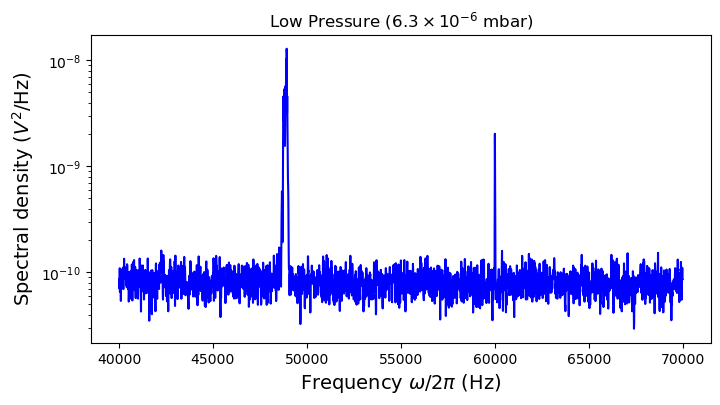

In [43]:
lb, ub = 4000, 7000
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ff[lb:ub], pp[lb:ub], 'b', label='Z detection')

ax.set_title(r'Low Pressure ($6.3 \times 10^{-6}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)', fontsize=14)
ax.set_ylabel('Spectral density ($V^2$/Hz)', fontsize=14)

# ax.set_ylim(1e-10)
ax.set_yscale('log')

In [49]:
drive_amp = 1 # V; peak to peak
f_drive = 60000
omega_drive = f_drive * 2 * np.pi

# Electric force on the particle
charge = 3 * 1.6e-19
efield = 120          # V/m when 1 V is applied
amp = drive_amp / 2   # Because what's in the file is the peak-to-peak amplitude and we want the amp from zero
f0 = charge * amp * efield

# Particle mass
rho = 2000 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

x2 = (f0**2 / (2 * m**2) ) / ((omega0_low**2 - omega_drive**2)**2 + gamma_low**2 * omega_drive**2)

v2_drive = get_peak_area(data, 1, 'ms', f_drive)
c_cal_square = v2_drive / x2

print(f'Calibration factor square is {c_cal_square}.')

Calibration factor square is 3976893637150.9.


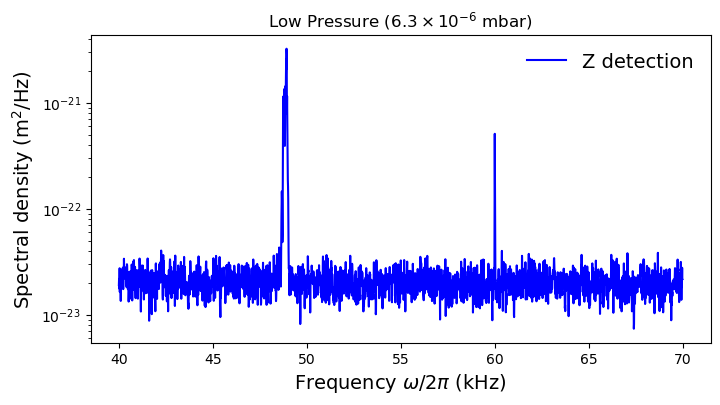

In [51]:
lb, ub = 4000, 7000
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ff[lb:ub]/1000, pp[lb:ub]/c_cal_square, 'b', label='Z detection')

ax.set_title(r'Low Pressure ($6.3 \times 10^{-6}$ mbar)')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel('Spectral density (m$^2$/Hz)', fontsize=14)

ax.legend(frameon=False, fontsize=14)
ax.set_yscale('log')

## Apply electric kicks

#### 21.5 MeV pulses

The data seem weird so will not analyze these. Use the old (shorter) data instead.

In [39]:
file_kick_1 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain_2nd\20240222_25v_8us_5e-6mbar_highergain_2nd_1.csv"
file_kick_2 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain_2nd\20240222_25v_8us_5e-6mbar_highergain_2nd_2.csv"
file_kick_3 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain_2nd\20240222_25v_8us_5e-6mbar_highergain_2nd_3.csv"
file_kick_4 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain_2nd\20240222_25v_8us_5e-6mbar_highergain_2nd_4.csv"

data_kick_1 = np.genfromtxt(file_kick_1, delimiter=',', skip_header=3).T
data_kick_2 = np.genfromtxt(file_kick_2, delimiter=',', skip_header=3).T
data_kick_3 = np.genfromtxt(file_kick_3, delimiter=',', skip_header=3).T
data_kick_4 = np.genfromtxt(file_kick_4, delimiter=',', skip_header=3).T

Text(0.5, 0.98, '21.5 MeV Pulses')

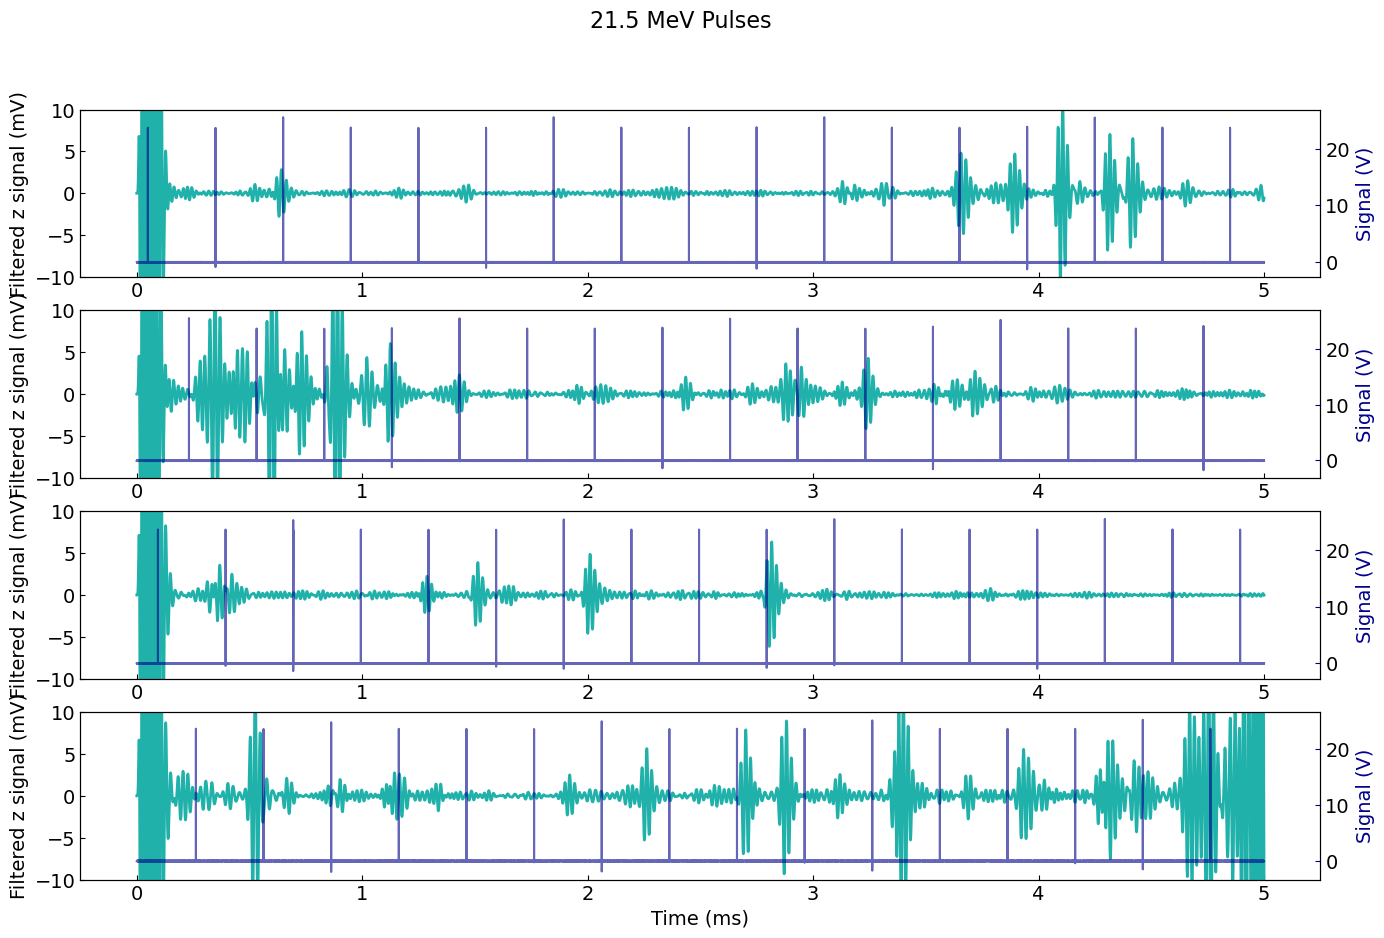

In [42]:
c_cal_square = 3976893637150.9
data_kick = [data_kick_1, data_kick_2, data_kick_3, data_kick_4]

fig, ax = plt.subplots(4, 1, figsize = (16, 10))

for i, d in enumerate(data_kick):    
    filtered = get_filtered_signal(d, 47000, 52000, 'ms')
    
    # z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    z_mv = filtered*1000
    fs = int(np.ceil(1 / (d[0, 1]/1000 - d[0, 0]/1000))) 

    lp_filtered = lowpass_filtered(z_mv, fs, 20)

    a = ax[i]
    a.plot(d[0][0:5000000], z_mv[0:5000000], label="Z detection (filtered)", color='lightseagreen', linewidth=2)
    a2 = a.twinx()

    a2.plot(d[0][0:5000000], d[2][0:5000000], 'darkblue', alpha=0.6)

    a2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    a.set_ylabel('Filtered z signal (mV)', fontsize=14)

    a2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    # ax2.set_ylim(0, 21)

for a in ax.flatten():
    a.set_ylim(-10, 10)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[3].set_xlabel('Time (ms)', fontsize=14)
plt.suptitle('21.5 MeV Pulses', fontsize=16)

In [14]:
file_kick_1 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain\20240222_25v_8us_5e-6mbar_highergain_1.csv"
file_kick_2 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain\20240222_25v_8us_5e-6mbar_highergain_2.csv"
file_kick_3 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain\20240222_25v_8us_5e-6mbar_highergain_3.csv"
file_kick_4 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain\20240222_25v_8us_5e-6mbar_highergain_4.csv"
file_kick_5 = r"C:\Users\yuhan\Documents\Data\pulse\20240222_25v_8us_5e-6mbar_highergain\20240222_25v_8us_5e-6mbar_highergain_5.csv"

data_kick_1 = np.genfromtxt(file_kick_1, delimiter=',', skip_header=3).T
data_kick_2 = np.genfromtxt(file_kick_2, delimiter=',', skip_header=3).T
data_kick_3 = np.genfromtxt(file_kick_3, delimiter=',', skip_header=3).T
data_kick_4 = np.genfromtxt(file_kick_4, delimiter=',', skip_header=3).T
data_kick_5 = np.genfromtxt(file_kick_5, delimiter=',', skip_header=3).T

Text(0.5, 0.98, '21.5 MeV Pulses')

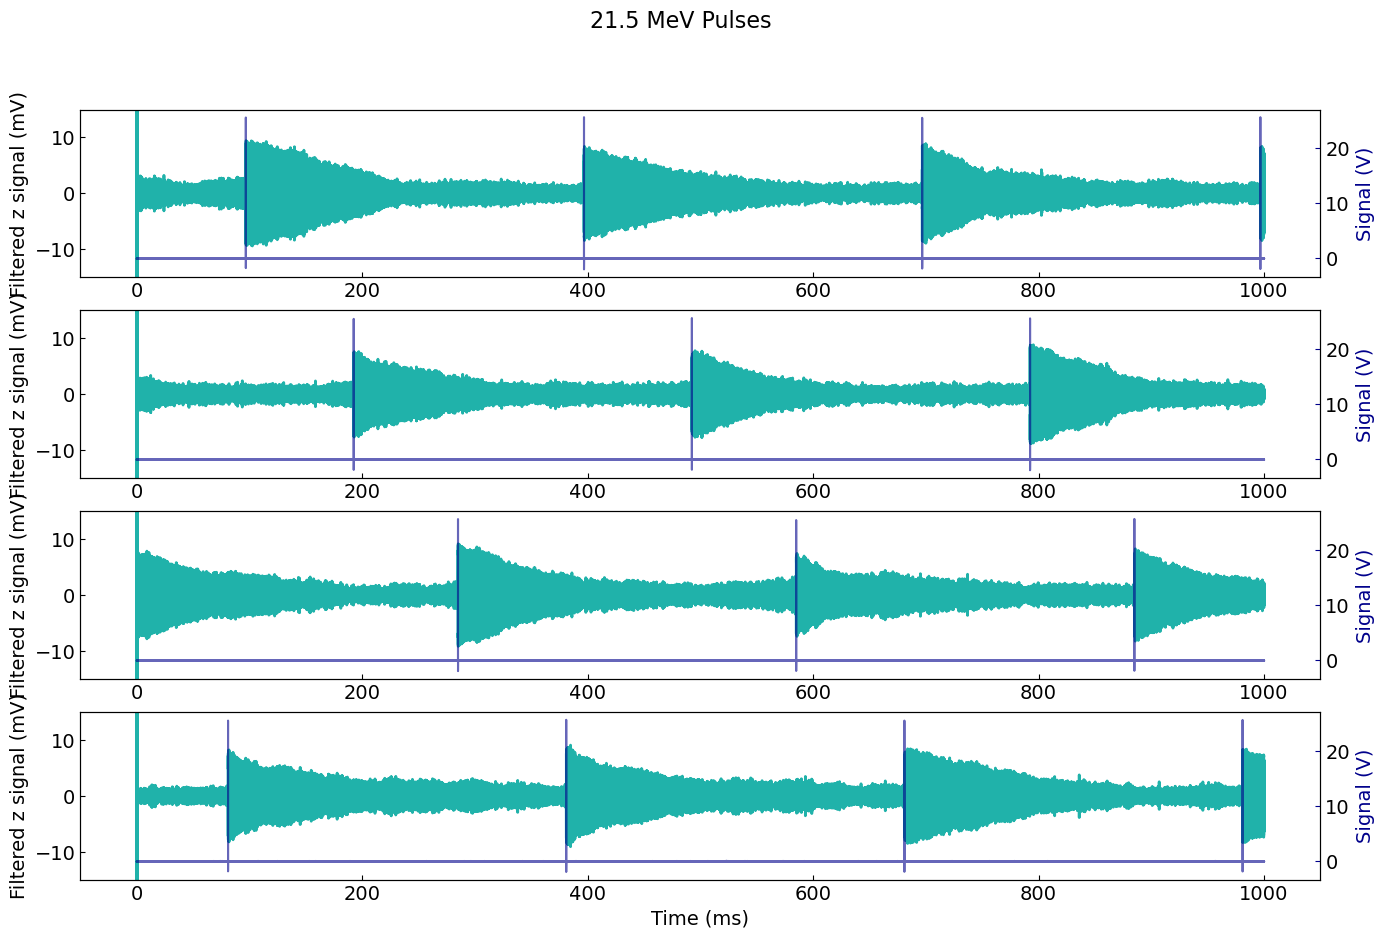

In [44]:
c_cal_square = 3976893637150.9
data_kick = [data_kick_1, data_kick_2, data_kick_3, data_kick_4]

fig, ax = plt.subplots(5, 1, figsize = (20, 10))

for i, d in enumerate(data_kick):    
    filtered = get_filtered_signal(d, 47000, 52000, 'ms')
    
    # z_nm = filtered/np.sqrt(c_cal_square)/1e-9
    z_mv = filtered*1000
    fs = int(np.ceil(1 / (d[0, 1]/1000 - d[0, 0]/1000)))

    # lp_filtered = lowpass_filtered(z_mv, fs, 20)

    a = ax[i]
    a.plot(d[0], z_mv, label="Z detection (filtered)", color='lightseagreen', linewidth=2)
    a2 = a.twinx()

    a2.plot(d[0], d[3], 'darkblue', alpha=0.6)

    a2.set_ylabel('Signal (V)', fontsize=14, color='darkblue')
    a.set_ylabel('Filtered z signal (mV)', fontsize=14)

    a2.tick_params(axis='both', which='both', direction='in', labelsize=14, color='darkblue')
    # ax2.set_ylim(0, 21)

for a in ax.flatten():
    a.set_ylim(-15, 15)
    a.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
ax[3].set_xlabel('Time (ms)', fontsize=14)
plt.suptitle('21.5 MeV Pulses', fontsize=16)

In [6]:
def pulse_template(tt, omega0, amp, beta):
    return np.exp(-1 * beta * tt) * np.sin(np.sqrt(omega0**2 - beta**2) * tt) / np.sqrt(omega0**2 - beta**2)

(0.0, 0.2)

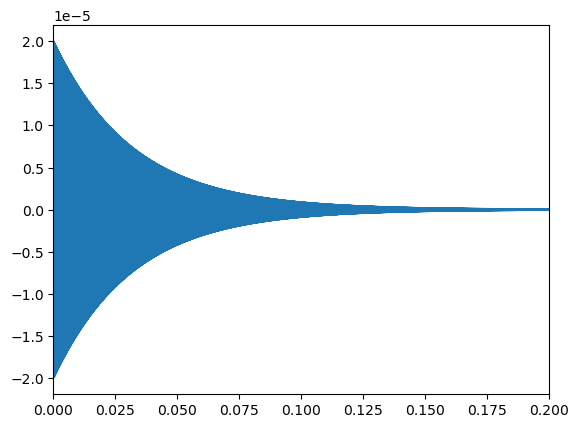

In [12]:
tt = np.linspace(0, 1, int(1e6))
plt.plot(tt, pulse_template(tt, 50000, 1, 5*2*np.pi))

plt.xlim(0, 0.2)